In [1]:
import pandas as pd
import numpy as np
import plotnine as gg
import pymc3 as pm
from theano import tensor as tt
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import string
from itertools import product
from numpy.random import normal, exponential, seed
import warnings

# Remove annoying filters from some dated ArViz functions.
warnings.simplefilter(action="ignore", category=UserWarning)

# Default theme for Plotnine.
gg.theme_set(gg.theme_minimal())

# A value to use in all random seed setting instances.
RANDOM_SEED = 103

---

## Model 7. 2-Dimensional varying intercept.

Model the effects of knocking out gene $g$ with sgRNA $s$ in cell line $c$.
The data will be generated with the following model, but then different models structures will be tested.

$
logFC_{s,c} \sim \mathcal{N}(\mu_{s,c}, \sigma) \\
\mu_{s,c} = \alpha_s + \beta_c \\
\quad \alpha_s \sim \mathcal{N}(\mu_{\alpha_s}, \sigma_\alpha) \\
\qquad \mu_{\alpha_s} = \gamma_g \\
\qquad\quad \gamma_g \sim \mathcal{N}(\mu_\gamma, \sigma_\gamma) \\
\qquad\qquad \mu_\gamma \sim \mathcal{N}(0, 5) \quad \sigma_\gamma \sim \text{Exp}(1) \\
\qquad \sigma_\alpha \sim \text{Exp}(1) \\
\quad \beta_c \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\qquad \mu_\beta \sim \mathcal{N}(0, 5) \quad \sigma_\beta \sim \text{Exp}(1) \\
\sigma \sim \text{Exp}(1)
$

Simulated values:

- number of cell lines: 20
- number of genes: 10
- number of repeated measures: $[1 , 2 , \dots , 10]$
- $\mu_\gamma = -1.0$, $\sigma_\gamma = 0.5$
- $\sigma_\alpha = 0.2$
- $\mu_\beta = 0$, $\sigma_\beta = 1$
- $\sigma = 0.3$

In [53]:
def prefixed_count(prefix, n, plus=0):
    """Make an array of 1-n with the number and some prefix."""
    return [prefix + str(i + plus) for i in range(n)]

In [54]:
def make_cat(df, col, ordered=True):
    """Make a column of a data frame into a categorical data type."""
    vals = df[col].drop_duplicates().to_list()
    df[col] = pd.Categorical(df[col], categories=vals, ordered=ordered)
    return df

In [78]:
seed(RANDOM_SEED)

num_cell_lines = 20
num_genes = 10
num_sgrna_per_gene = list(range(1, num_genes + 1))
num_sgrnas = sum(num_sgrna_per_gene)

cell_lines = prefixed_count("cell_", num_cell_lines)
genes = prefixed_count("gene_", num_genes)
sgrna = prefixed_count("sgRNA_", num_sgrnas)

# RP ("real parameters")
RP = {
    "mu_gamma": -1.0,
    "sigma_gamma": 0.5,
    "sigma_alpha": 0.2,
    "mu_beta": 0.0,
    "sigma_beta": 1.0,
    "sigma": 0.3,
}

RP["gamma_g"] = normal(loc=RP["mu_gamma"], scale=RP["sigma_gamma"], size=num_genes)
RP["beta_c"] = normal(loc=RP["mu_beta"], scale=RP["sigma_beta"], size=num_cell_lines)

sgrna_df = pd.DataFrame({"gene": np.repeat(genes, num_sgrna_per_gene), "sgRNA": sgrnas})
for col in sgrna_df.columns:
    sgrna_df = make_cat(sgrna_df, col)

alpha_s = []
for gene_i in sgrna_df["gene"].cat.codes:
    alpha_s.append(normal(loc=RP["gamma_g"][gene_i], scale=RP["sigma_alpha"]))


RP["alpha_s"] = alpha_s

data = pd.DataFrame(product(cell_lines, sgrnas), columns=["cell_line", "sgRNA"])
data = data.merge(sgrna_df, on="sgRNA")


for col in data.columns:
    data = make_cat(data, col)


for i in range(len(data)):
    cell_i = data["cell_line"].cat.codes[i]
    sgrna_i = data["sgRNA"].cat.codes[i]
    mu_sc = RP["alpha_s"][sgrna_i] + RP["beta_c"][cell_i]
    data.loc[i, "mu_sc"] = mu_sc
    data.loc[i, "log_fc"] = normal(loc=mu_sc, scale=RP["sigma"])

data

,cell_line,sgRNA,gene,mu_sc,log_fc
0,cell_0,sgRNA_1,gene_0,-1.284686,-0.974021
1,cell_1,sgRNA_1,gene_0,-1.986886,-2.358464
2,cell_2,sgRNA_1,gene_0,-0.883180,-0.911884
3,cell_3,sgRNA_1,gene_0,-0.267206,-0.774813
4,cell_4,sgRNA_1,gene_0,-3.064072,-2.866197
...,...,...,...,...,...
1095,cell_15,sgRNA_55,gene_9,-2.116856,-2.188318
1096,cell_16,sgRNA_55,gene_9,-2.245777,-1.630069
1097,cell_17,sgRNA_55,gene_9,-1.079010,-0.752161
1098,cell_18,sgRNA_55,gene_9,-1.900383,-1.697479


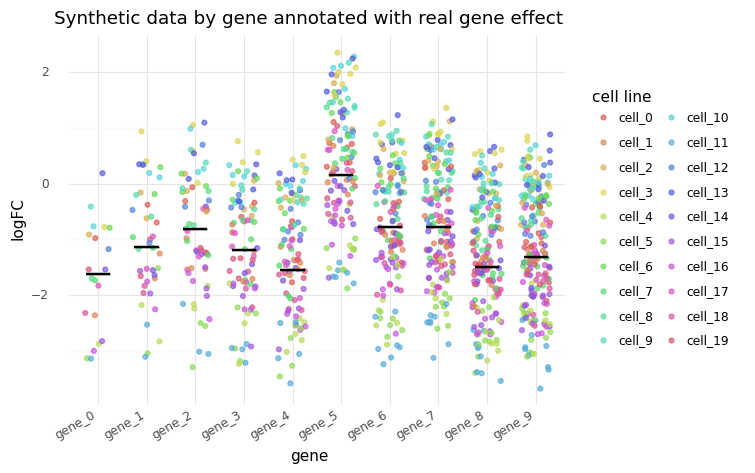

<ggplot: (8789184847839)>

In [105]:
real_gene_vals = pd.DataFrame({"gene": genes, "log_fc": RP["gamma_g"]})

(
    gg.ggplot(data, gg.aes(x="gene", y="log_fc"))
    + gg.geom_jitter(gg.aes(color="cell_line"), height=0, width=0.3, alpha=0.7)
    + gg.geom_crossbar(gg.aes(ymin="log_fc", ymax="log_fc"), data=real_gene_vals)
    + gg.scale_color_discrete(guide=gg.guide_legend(title="cell line", ncol=2))
    + gg.theme(axis_text_x=gg.element_text(angle=30, hjust=1, vjust=0.2))
    + gg.labs(
        x="gene",
        y="logFC",
        title="Synthetic data by gene annotated with real gene effect",
    )
)

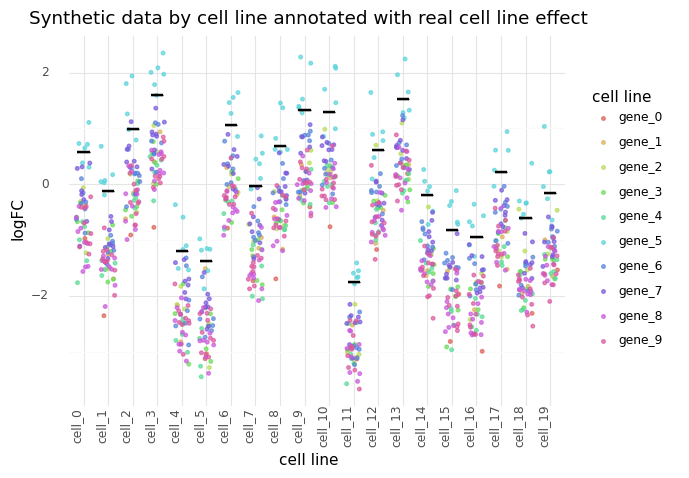

<ggplot: (8789192734458)>

In [113]:
real_cellline_vals = pd.DataFrame({"cell_line": cell_lines, "log_fc": RP["beta_c"]})

(
    gg.ggplot(data, gg.aes(x="cell_line", y="log_fc"))
    + gg.geom_jitter(gg.aes(color="gene"), height=0, width=0.3, alpha=0.7, size=1)
    + gg.geom_crossbar(gg.aes(ymin="log_fc", ymax="log_fc"), data=real_cellline_vals)
    + gg.scale_color_discrete(guide=gg.guide_legend(title="cell line", ncol=1))
    + gg.theme(axis_text_x=gg.element_text(angle=90, hjust=1, vjust=0.5))
    + gg.labs(
        x="cell line",
        y="logFC",
        title="Synthetic data by cell line annotated with real cell line effect",
    )
)

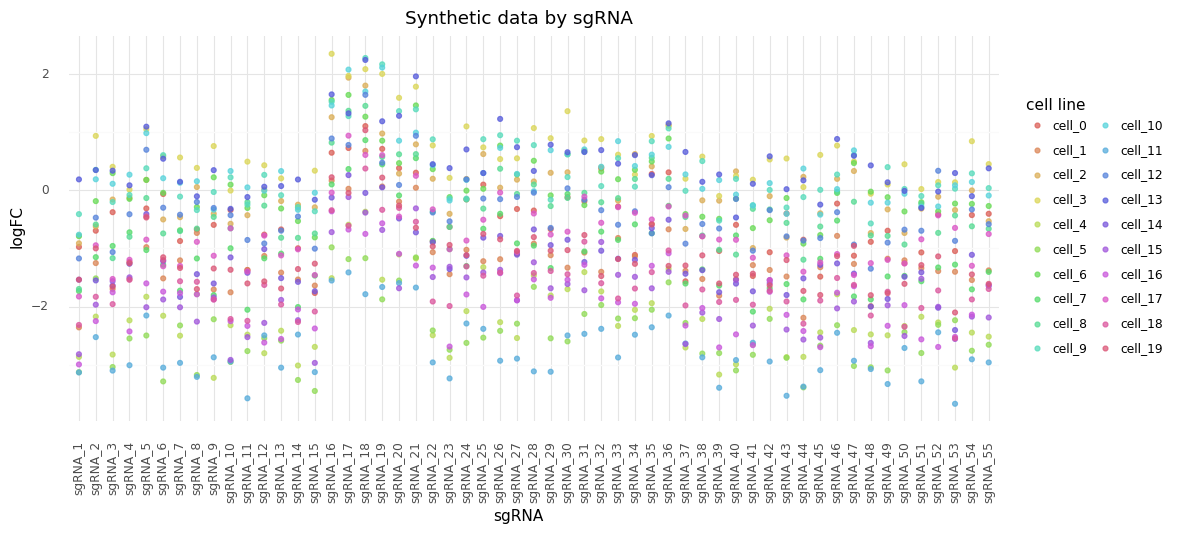

<ggplot: (8789182697602)>

In [138]:
real_cellline_vals = pd.DataFrame({"cell_line": cell_lines, "log_fc": RP["beta_c"]})

(
    gg.ggplot(data, gg.aes(x="sgRNA", y="log_fc"))
    + gg.geom_jitter(gg.aes(color="cell_line"), height=0, width=0, alpha=0.75)
    + gg.scale_color_discrete(guide=gg.guide_legend(title="cell line", ncol=2))
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1), figure_size=(12, 5)
    )
    + gg.labs(x="sgRNA", y="logFC", title="Synthetic data by sgRNA",)
)

$
logFC_{s,c} \sim \mathcal{N}(\mu_{s,c}, \sigma) \\
\mu_{s,c} = \alpha_{s} + \beta_{c} \\
\quad \alpha_{s} \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\qquad \mu_\alpha \sim \
\quad \beta_{c} \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\qquad \mu_\beta \sim \mathcal{N}(0, 5) \quad \sigma_\beta \sim \text{Exp}(1) \\
\sigma \sim \text{Exp}(1)
$

---

In [31]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

numpy    1.19.2
seaborn  0.11.0
plotnine 0.7.1
arviz    0.10.0
pandas   1.1.3
pymc3    3.9.3
last updated: 2020-11-07 

CPython 3.8.5
IPython 7.18.1

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-1062.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 28
interpreter: 64bit
host name  : compute-e-16-229.o2.rc.hms.harvard.edu
Git branch : models
